In [1]:
# Import libraries
import duckdb
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
# Configuration
DATA_DIR = Path("../data")
TRADES_GLOB = str(DATA_DIR / "trades" / "**" / "*.parquet")
MARKETS_GLOB = str(DATA_DIR / "gamma_markets" / "**" / "*.parquet")
LEADERBOARD_GLOB = str(DATA_DIR / "leaderboard" / "**" / "*.parquet")

# Time split point
SPLIT_DATE = datetime(2024, 11, 1)

print(f"Trades dir: {DATA_DIR / 'trades'}")
print(f"Markets dir: {DATA_DIR / 'gamma_markets'}")
print(f"Leaderboard dir: {DATA_DIR / 'leaderboard'}")
print(f"\nSplit date: {SPLIT_DATE}")

Trades dir: ..\data\trades
Markets dir: ..\data\gamma_markets
Leaderboard dir: ..\data\leaderboard

Split date: 2024-11-01 00:00:00


In [3]:
# Create DuckDB connection and load data
conn = duckdb.connect(":memory:")

# Attach the silver database if available
silver_db = Path(r"C:\Users\User\Desktop\VibeCoding\PolyMarketData\silver.duckdb")
polymarket_db = Path(r"C:\Users\User\Desktop\VibeCoding\PolyMarketData\polymarket.duckdb")

if polymarket_db.exists():
    conn.execute(f"ATTACH '{polymarket_db}' AS marketdb (READ_ONLY)")
    print(f"Attached polymarket DB: {polymarket_db}")

# Create views for parquet files
conn.execute(f"""
    CREATE VIEW trades AS 
    SELECT * FROM read_parquet('{TRADES_GLOB}', hive_partitioning=true)
""")
print("Created trades view")

# Check if leaderboard data exists
leaderboard_path = DATA_DIR / "leaderboard"
if leaderboard_path.exists() and any(leaderboard_path.rglob("*.parquet")):
    conn.execute(f"""
        CREATE VIEW leaderboard AS 
        SELECT * FROM read_parquet('{LEADERBOARD_GLOB}', hive_partitioning=true)
    """)
    print("Created leaderboard view")

# Check if gamma markets data exists
markets_path = DATA_DIR / "gamma_markets"
if markets_path.exists() and any(markets_path.rglob("*.parquet")):
    conn.execute(f"""
        CREATE VIEW gamma_markets AS 
        SELECT * FROM read_parquet('{MARKETS_GLOB}', hive_partitioning=true)
    """)
    print("Created gamma_markets view")

Attached polymarket DB: C:\Users\User\Desktop\VibeCoding\PolyMarketData\polymarket.duckdb
Created trades view
Created leaderboard view
Created gamma_markets view


In [ ]:
# Check available tables and their schemas
print("=== Trades Schema ===")
display(conn.execute("DESCRIBE trades").fetchdf())

In [ ]:
# Check leaderboard schema if available
try:
    print("\n=== Leaderboard Schema ===")
    display(conn.execute("DESCRIBE leaderboard").fetchdf())
except:
    print("Leaderboard view not available")

In [5]:
# Check gamma markets schema if available
try:
    print("\n=== Gamma Markets Schema ===")
    display(conn.execute("DESCRIBE gamma_markets").fetchdf())
except:
    print("Gamma markets view not available")


=== Gamma Markets Schema ===


,column_name,column_type,null,key,default,extra
0,id,VARCHAR,YES,None,None,None
1,conditionId,VARCHAR,YES,None,None,None
2,question,VARCHAR,YES,None,None,None
3,slug,VARCHAR,YES,None,None,None
4,category,VARCHAR,YES,None,None,None
5,description,VARCHAR,YES,None,None,None
6,liquidity,VARCHAR,YES,None,None,None
7,volume,VARCHAR,YES,None,None,None
8,active,BOOLEAN,YES,None,None,None
9,closed,BOOLEAN,YES,None,None,None


In [6]:
# Check MarketDim if attached
try:
    print("\n=== MarketDim Schema ===")
    display(conn.execute("DESCRIBE marketdb.MarketDim").fetchdf())
except:
    print("MarketDim not available")


=== MarketDim Schema ===


,column_name,column_type,null,key,default,extra
0,market_id,INTEGER,NO,PRI,None,None
1,external_id,VARCHAR,NO,UNI,None,None
2,event_id,INTEGER,YES,None,None,None
3,question,VARCHAR,NO,None,None,None
4,active,BOOLEAN,YES,None,CAST('t' AS BOOLEAN),None
5,end_date_iso,TIMESTAMP,YES,None,None,None
6,Outcome,VARCHAR,YES,None,None,None
7,start_date_iso,TIMESTAMP,YES,None,None,None
8,VolumeNum,VARCHAR,YES,None,None,None
9,created_at,TIMESTAMP,YES,None,CURRENT_TIMESTAMP,None


## Basic Statistics

In [ ]:
# Get basic trade statistics
trade_stats = conn.execute("""
    SELECT 
        COUNT(*) as total_trades,
        COUNT(DISTINCT proxyWallet) as unique_traders,
        COUNT(DISTINCT conditionId) as unique_markets,
        MIN(timestamp) as earliest_trade_ts,
        MAX(timestamp) as latest_trade_ts,
        SUM(size * price) as total_volume
    FROM trades
""").fetchdf()

# Convert timestamps to readable dates
trade_stats['earliest_trade'] = pd.to_datetime(trade_stats['earliest_trade_ts'], unit='s')
trade_stats['latest_trade'] = pd.to_datetime(trade_stats['latest_trade_ts'], unit='s')

display(trade_stats)

## Top Traders Analysis

In [ ]:
# Calculate top traders by volume
top_traders = conn.execute("""
    SELECT 
        proxyWallet,
        COUNT(*) as trade_count,
        COUNT(DISTINCT conditionId) as markets_traded,
        SUM(size * price) as total_volume,
        AVG(price) as avg_price
    FROM trades
    GROUP BY proxyWallet
    ORDER BY total_volume DESC
    LIMIT 50
""").fetchdf()

print(f"Top 50 Traders by Volume:")
display(top_traders)

## Before vs After November 2024 Split

In [ ]:
# November 2024 timestamp
nov_2024_ts = int(SPLIT_DATE.timestamp())
print(f"Split timestamp: {nov_2024_ts} ({SPLIT_DATE})")

# Get time range of our data
time_range = conn.execute("""
    SELECT 
        MIN(timestamp) as min_ts,
        MAX(timestamp) as max_ts
    FROM trades
""").fetchone()

print(f"Data range: {datetime.fromtimestamp(time_range[0])} to {datetime.fromtimestamp(time_range[1])}")

In [ ]:
# Top traders BEFORE November 2024
top_traders_before = conn.execute(f"""
    SELECT 
        proxyWallet,
        COUNT(*) as trade_count,
        COUNT(DISTINCT conditionId) as markets_traded,
        SUM(size * price) as total_volume,
        AVG(price) as avg_price,
        SUM(CASE WHEN side = 'BUY' THEN size * price ELSE 0 END) as buy_volume,
        SUM(CASE WHEN side = 'SELL' THEN size * price ELSE 0 END) as sell_volume
    FROM trades
    WHERE timestamp < {nov_2024_ts}
    GROUP BY proxyWallet
    ORDER BY total_volume DESC
    LIMIT 25
""").fetchdf()

print(f"=== Top 25 Traders BEFORE November 2024 ===")
display(top_traders_before)

In [ ]:
# Top traders AFTER November 2024
top_traders_after = conn.execute(f"""
    SELECT 
        proxyWallet,
        COUNT(*) as trade_count,
        COUNT(DISTINCT conditionId) as markets_traded,
        SUM(size * price) as total_volume,
        AVG(price) as avg_price,
        SUM(CASE WHEN side = 'BUY' THEN size * price ELSE 0 END) as buy_volume,
        SUM(CASE WHEN side = 'SELL' THEN size * price ELSE 0 END) as sell_volume
    FROM trades
    WHERE timestamp >= {nov_2024_ts}
    GROUP BY proxyWallet
    ORDER BY total_volume DESC
    LIMIT 25
""").fetchdf()

print(f"=== Top 25 Traders AFTER November 2024 ===")
display(top_traders_after)

In [ ]:
# Compare performance before and after for traders active in both periods
trader_comparison = conn.execute(f"""
    WITH before_stats AS (
        SELECT 
            proxyWallet,
            COUNT(*) as before_trades,
            SUM(size * price) as before_volume,
            COUNT(DISTINCT conditionId) as before_markets
        FROM trades
        WHERE timestamp < {nov_2024_ts}
        GROUP BY proxyWallet
    ),
    after_stats AS (
        SELECT 
            proxyWallet,
            COUNT(*) as after_trades,
            SUM(size * price) as after_volume,
            COUNT(DISTINCT conditionId) as after_markets
        FROM trades
        WHERE timestamp >= {nov_2024_ts}
        GROUP BY proxyWallet
    )
    SELECT 
        COALESCE(b.proxyWallet, a.proxyWallet) as proxyWallet,
        COALESCE(b.before_trades, 0) as before_trades,
        COALESCE(a.after_trades, 0) as after_trades,
        COALESCE(b.before_volume, 0) as before_volume,
        COALESCE(a.after_volume, 0) as after_volume,
        COALESCE(a.after_volume, 0) - COALESCE(b.before_volume, 0) as volume_change,
        CASE 
            WHEN COALESCE(b.before_volume, 0) > 0 
            THEN (COALESCE(a.after_volume, 0) - b.before_volume) / b.before_volume * 100 
            ELSE NULL 
        END as volume_change_pct
    FROM before_stats b
    FULL OUTER JOIN after_stats a ON b.proxyWallet = a.proxyWallet
    WHERE COALESCE(b.before_trades, 0) + COALESCE(a.after_trades, 0) > 10
    ORDER BY COALESCE(b.before_volume, 0) + COALESCE(a.after_volume, 0) DESC
    LIMIT 30
""").fetchdf()

print("=== Trader Comparison: Before vs After November 2024 ===")
display(trader_comparison)

## Category Analysis

In [4]:
# Check if we have category data from MarketDim or gamma_markets
try:
    # Try to get categories from MarketDim
    categories = conn.execute("""
        SELECT DISTINCT category, COUNT(*) as market_count
        FROM marketdb.MarketDim
        WHERE category IS NOT NULL
        GROUP BY category
        ORDER BY market_count DESC
    """).fetchdf()
    print("=== Available Categories (from MarketDim) ===")
    display(categories)
except Exception as e:
    print(f"Could not get categories from MarketDim: {e}")
    
    # Try gamma_markets
    try:
        categories = conn.execute("""
            SELECT DISTINCT * FROM gamma_markets LIMIT 5
        """).fetchdf()
        print("=== Sample gamma_markets data ===")
        display(categories)
    except Exception as e2:
        print(f"Could not get gamma_markets data: {e2}")

Could not get categories from MarketDim: Binder Error: Referenced column "category" not found in FROM clause!
Candidate bindings: "active", "created_at", "Outcome"

LINE 4:         WHERE category IS NOT NULL
                      ^
=== Sample gamma_markets data ===


,id,conditionId,question,slug,category,description,liquidity,volume,active,closed,startDate,endDate,outcomes,outcomePrices,clobTokenIds,volumeNum,liquidityNum,marketGroup,dt
0,252730,0x5d0c7869d6bbd5c926178c5ebb2c1ab1afa3e1b04bd0...,Will the Fed raise interest rates by 25 bps af...,will-the-fed-raise-interest-rates-by-25-bps-af...,,The FED interest rates are defined in this mar...,0,27152.23446,True,True,2023-10-23T18:04:49.955Z,2023-12-13T00:00:00Z,"[""Yes"", ""No""]","[""0"", ""1""]","[""11557098112384218749689436062694562246714992...",27152.23,0.0,0,2025-12-26
1,252758,0xdf24547cb6e7ef339d859d387f6cd2260d7de411b694...,Colts vs. Saints,nfl-ind-no-2023-10-29,,"In the upcoming NFL game, scheduled for Octobe...",0,229.666665,True,True,2023-10-29T00:00:00Z,2023-10-29T00:00:00Z,"[""Colts"", ""Saints""]","[""0"", ""1""]","[""23424457430586089620761822980954135842560129...",229.67,0.0,0,2025-12-26
2,252781,0x27ac1128f22286898566b29bd09d397c3490fe8d8068...,Pacers vs. Wizards,nba-ind-wsh-2023-10-25,,"In the upcoming NBA game, scheduled for Octobe...",0,0,True,True,2023-10-25T00:00:00Z,2023-10-25T00:00:00Z,"[""Pacers"", ""Wizards""]","[""1"", ""0""]","[""27964233543994535560851580663984900304284425...",0.00,0.0,0,2025-12-26
3,252791,0x05f18e8ea94b98520835ba6edb32a0d91cb48f17583d...,Bucks vs. 76ers,nba-mil-phi-2023-10-26,,"In the upcoming NBA game, scheduled for Octobe...",0,342.759364,True,True,2023-10-26T00:00:00Z,2023-10-26T00:00:00Z,"[""Bucks"", ""76ers""]","[""1"", ""0""]","[""60471826976391704257118359318243114633010627...",342.76,0.0,0,2025-12-26
4,252805,0x9dcf386445d2f4091ef09b39fe788ad61f1046a9c86a...,Wizards vs. Grizzlies,nba-wsh-mem-2023-10-28,,"In the upcoming NBA game, scheduled for Octobe...",0,0,True,True,2023-10-28T00:00:00Z,2023-10-28T00:00:00Z,"[""Wizards"", ""Grizzlies""]","[""1"", ""0""]","[""98374126476148232736368607775712049277451773...",0.00,0.0,0,2025-12-26


In [7]:
# Explore gamma_markets schema and sample data
gamma_schema = conn.execute("DESCRIBE gamma_markets").fetchdf()
print("=== Gamma Markets Columns ===")
print(gamma_schema['column_name'].tolist())

=== Gamma Markets Columns ===
['id', 'conditionId', 'question', 'slug', 'category', 'description', 'liquidity', 'volume', 'active', 'closed', 'startDate', 'endDate', 'outcomes', 'outcomePrices', 'clobTokenIds', 'volumeNum', 'liquidityNum', 'marketGroup', 'dt']


In [8]:
# Get available categories from gamma_markets
categories_df = conn.execute("""
    SELECT category, COUNT(*) as market_count
    FROM gamma_markets
    WHERE category IS NOT NULL AND category != ''
    GROUP BY category
    ORDER BY market_count DESC
""").fetchdf()
print("=== Available Categories ===")
display(categories_df)

=== Available Categories ===


,category,market_count
0,Sports,2552
1,Crypto,374
2,US-current-affairs,361
3,Pop-Culture,218
4,Coronavirus,153
5,Business,137
6,NBA Playoffs,126
7,NFTs,114
8,Chess,77
9,Art,61


In [9]:
# Analyze top bettors by category - Join trades with gamma_markets
top_bettors_by_category = conn.execute("""
    WITH trader_stats AS (
        SELECT 
            gm.category,
            t.proxyWallet,
            COUNT(*) as trade_count,
            SUM(t.size * t.price) as total_volume,
            SUM(CASE WHEN t.side = 'BUY' THEN t.size * t.price ELSE 0 END) as buy_volume,
            SUM(CASE WHEN t.side = 'SELL' THEN t.size * t.price ELSE 0 END) as sell_volume,
            COUNT(DISTINCT t.conditionId) as markets_traded
        FROM trades t
        INNER JOIN gamma_markets gm ON t.conditionId = gm.conditionId
        WHERE gm.category IS NOT NULL AND gm.category != ''
        GROUP BY gm.category, t.proxyWallet
    ),
    ranked AS (
        SELECT 
            *,
            ROW_NUMBER() OVER (PARTITION BY category ORDER BY total_volume DESC) as rank_in_category
        FROM trader_stats
    )
    SELECT *
    FROM ranked
    WHERE rank_in_category <= 5
    ORDER BY category, rank_in_category
""").fetchdf()

print("=== Top 5 Bettors Per Category ===")
display(top_bettors_by_category)

=== Top 5 Bettors Per Category ===


,category,proxyWallet,trade_count,total_volume,buy_volume,sell_volume,markets_traded,rank_in_category
0,Crypto,0x6dd6314d1670f9f1ccccbd6746b0bf2f2fa0f5f4,1,9.423000,9.423000,0.000000,1,1
1,Pop-Culture,0x569e37de70cfc302405dc0577ae46f3140bc67db,3,5022.030000,5022.030000,0.000000,1,1
2,Pop-Culture,0x01e8139026726b55b45b131873e2a5dcb6c7ce3b,1,4071.679969,4071.679969,0.000000,1,2
3,Pop-Culture,0x57ee8830ec5da8df6ac26415ecce470544fc7f26,1,450.000000,450.000000,0.000000,1,3
4,Pop-Culture,0xd15db42520b3e3fea429e768a9110457ea319f78,1,349.999992,349.999992,0.000000,1,4
5,Pop-Culture,0x17d5e2f2dcb09f4141ebf966310d125a03d895a6,4,328.000000,328.000000,0.000000,1,5
6,US-current-affairs,0x6356fb47642a028bc09df92023c35a21a0b41885,97,321658.047690,221083.838350,100574.209340,5,1
7,US-current-affairs,0x0c0e270cf879583d6a0142fc817e05b768d0434e,50,247129.904077,142905.137877,104224.766200,7,2
8,US-current-affairs,0xb532895e91e79422299d365c6bd0367ac35a916b,35,238887.842390,226547.299850,12340.542540,4,3
9,US-current-affairs,0x9d84ce0306f8551e02efef1680475fc0f1dc1344,58,225431.174381,187505.171631,37926.002750,5,4


In [10]:
# Aggregate statistics by category
category_stats = conn.execute("""
    SELECT 
        gm.category,
        COUNT(DISTINCT t.proxyWallet) as unique_traders,
        COUNT(*) as total_trades,
        SUM(t.size * t.price) as total_volume,
        AVG(t.size * t.price) as avg_trade_size,
        COUNT(DISTINCT t.conditionId) as unique_markets
    FROM trades t
    INNER JOIN gamma_markets gm ON t.conditionId = gm.conditionId
    WHERE gm.category IS NOT NULL AND gm.category != ''
    GROUP BY gm.category
    ORDER BY total_volume DESC
""").fetchdf()

print("=== Category Statistics Overview ===")
display(category_stats)

=== Category Statistics Overview ===


,category,unique_traders,total_trades,total_volume,avg_trade_size,unique_markets
0,US-current-affairs,2622,10175,9.316338e+06,915.610566,16
1,Pop-Culture,34,41,1.187096e+04,289.535574,1
2,Crypto,1,1,9.423000e+00,9.423000,1


## Category Comparison Visualizations

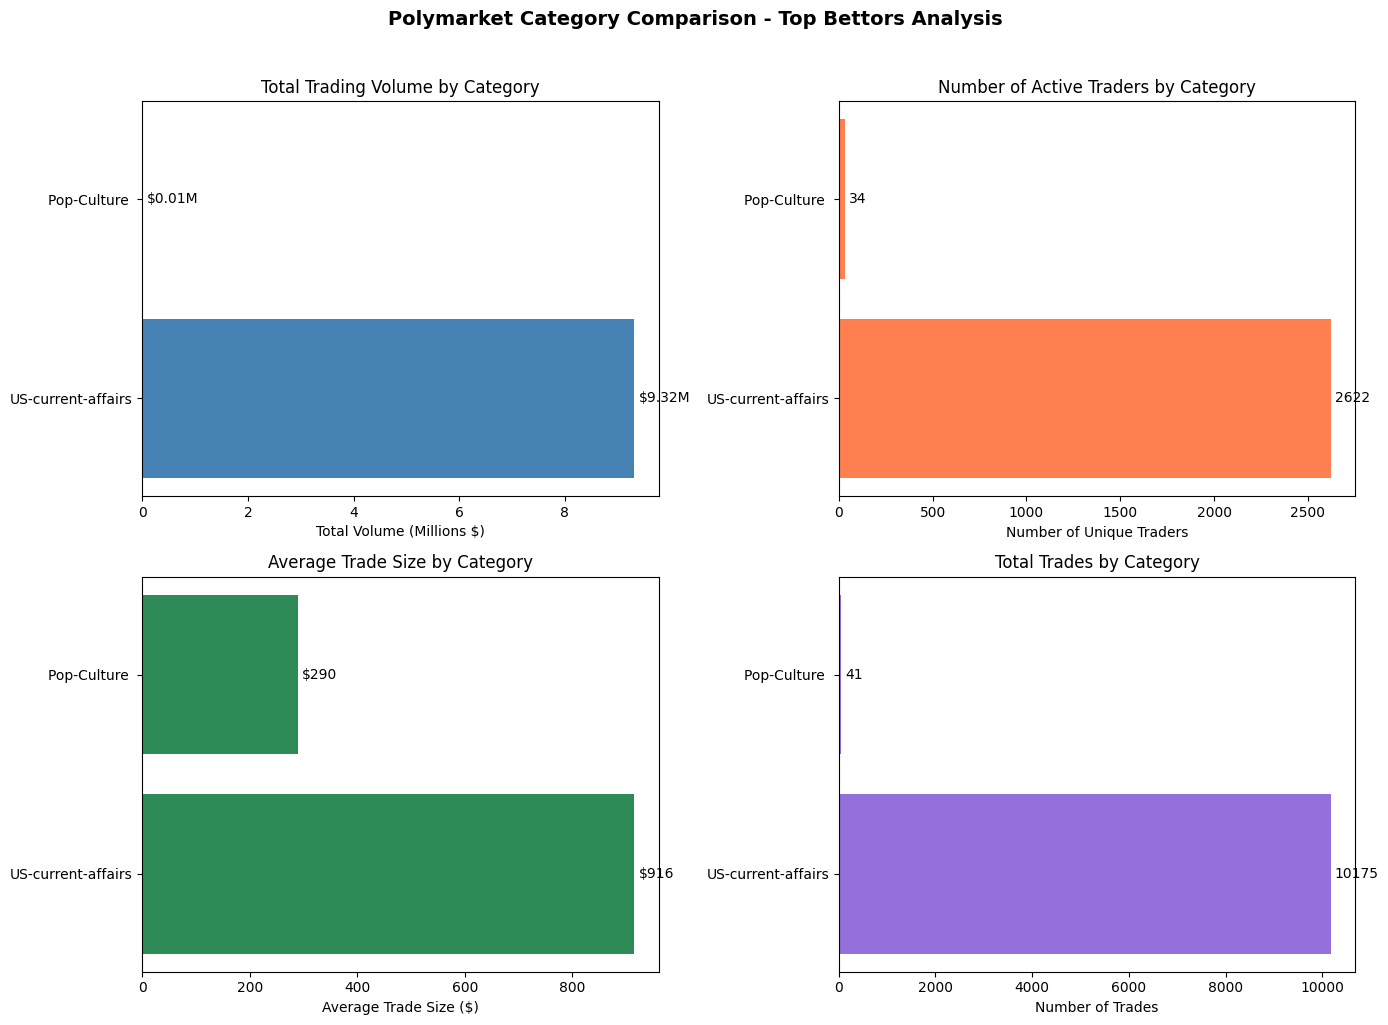

In [11]:
import matplotlib.pyplot as plt

# Create visualization comparing categories
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Filter to categories with meaningful data (more than 10 trades)
plot_data = category_stats[category_stats['total_trades'] >= 10].copy()

# 1. Total Volume by Category (Bar Chart)
ax1 = axes[0, 0]
bars1 = ax1.barh(plot_data['category'], plot_data['total_volume'] / 1e6, color='steelblue')
ax1.set_xlabel('Total Volume (Millions $)')
ax1.set_title('Total Trading Volume by Category')
ax1.bar_label(bars1, fmt='$%.2fM', padding=3)

# 2. Unique Traders by Category
ax2 = axes[0, 1]
bars2 = ax2.barh(plot_data['category'], plot_data['unique_traders'], color='coral')
ax2.set_xlabel('Number of Unique Traders')
ax2.set_title('Number of Active Traders by Category')
ax2.bar_label(bars2, fmt='%d', padding=3)

# 3. Average Trade Size by Category
ax3 = axes[1, 0]
bars3 = ax3.barh(plot_data['category'], plot_data['avg_trade_size'], color='seagreen')
ax3.set_xlabel('Average Trade Size ($)')
ax3.set_title('Average Trade Size by Category')
ax3.bar_label(bars3, fmt='$%.0f', padding=3)

# 4. Total Trades by Category
ax4 = axes[1, 1]
bars4 = ax4.barh(plot_data['category'], plot_data['total_trades'], color='mediumpurple')
ax4.set_xlabel('Number of Trades')
ax4.set_title('Total Trades by Category')
ax4.bar_label(bars4, fmt='%d', padding=3)

plt.suptitle('Polymarket Category Comparison - Top Bettors Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

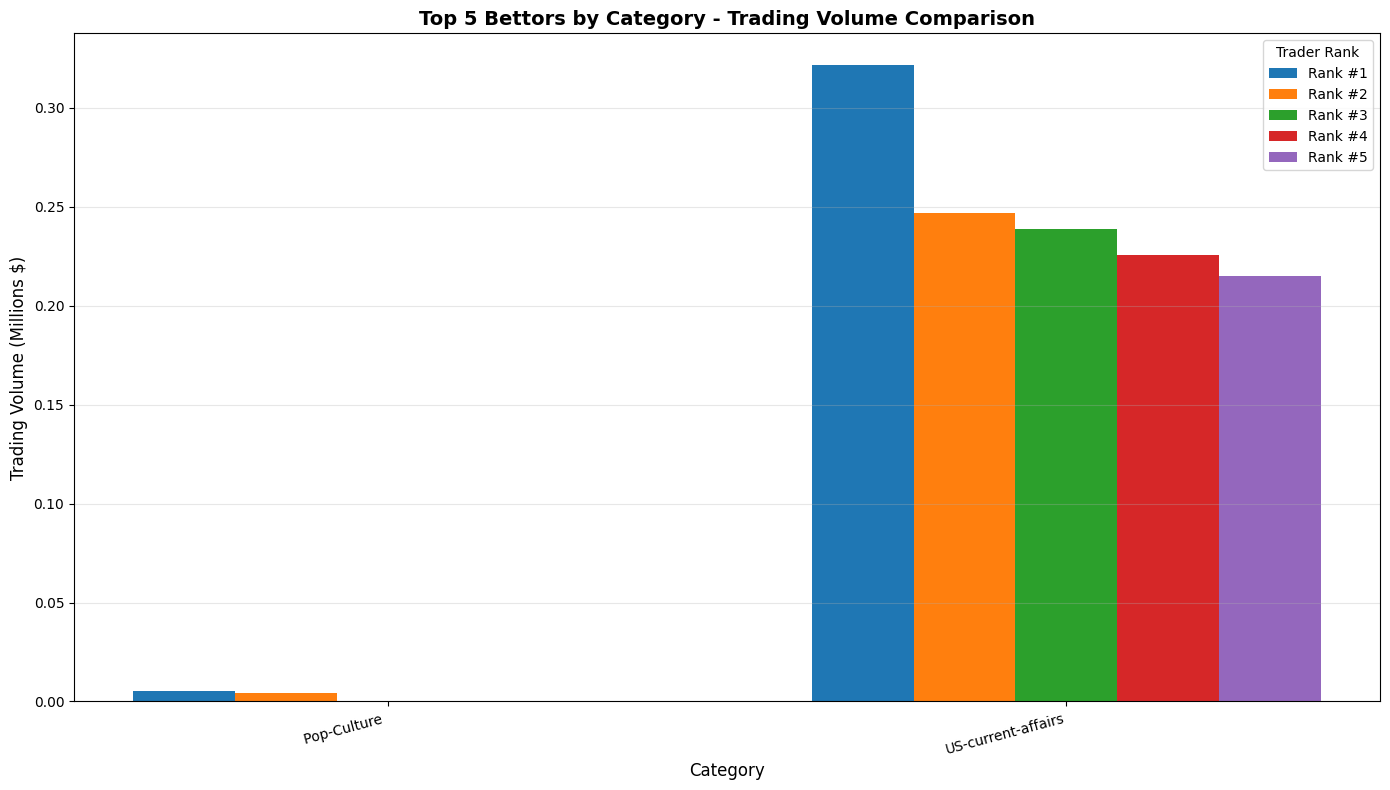

In [12]:
# Create a detailed visualization of top 5 bettors in each category
fig, ax = plt.subplots(figsize=(14, 8))

# Filter for categories with meaningful data
categories_with_data = top_bettors_by_category[
    top_bettors_by_category['category'].isin(plot_data['category'])
].copy()

# Create grouped bar chart for top traders by category
import numpy as np

categories = categories_with_data['category'].unique()
x = np.arange(len(categories))
width = 0.15

# Get top 5 traders for each category
for rank in range(1, 6):
    rank_data = categories_with_data[categories_with_data['rank_in_category'] == rank]
    volumes = []
    for cat in categories:
        cat_data = rank_data[rank_data['category'] == cat]
        if len(cat_data) > 0:
            volumes.append(cat_data['total_volume'].values[0] / 1e6)
        else:
            volumes.append(0)
    
    bars = ax.bar(x + (rank - 3) * width, volumes, width, label=f'Rank #{rank}')

ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Trading Volume (Millions $)', fontsize=12)
ax.set_title('Top 5 Bettors by Category - Trading Volume Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=15, ha='right')
ax.legend(title='Trader Rank')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_337244\828923006.py:38: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
c:\Users\User\Desktop\VibeCoding\PolyMarketScrapping\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


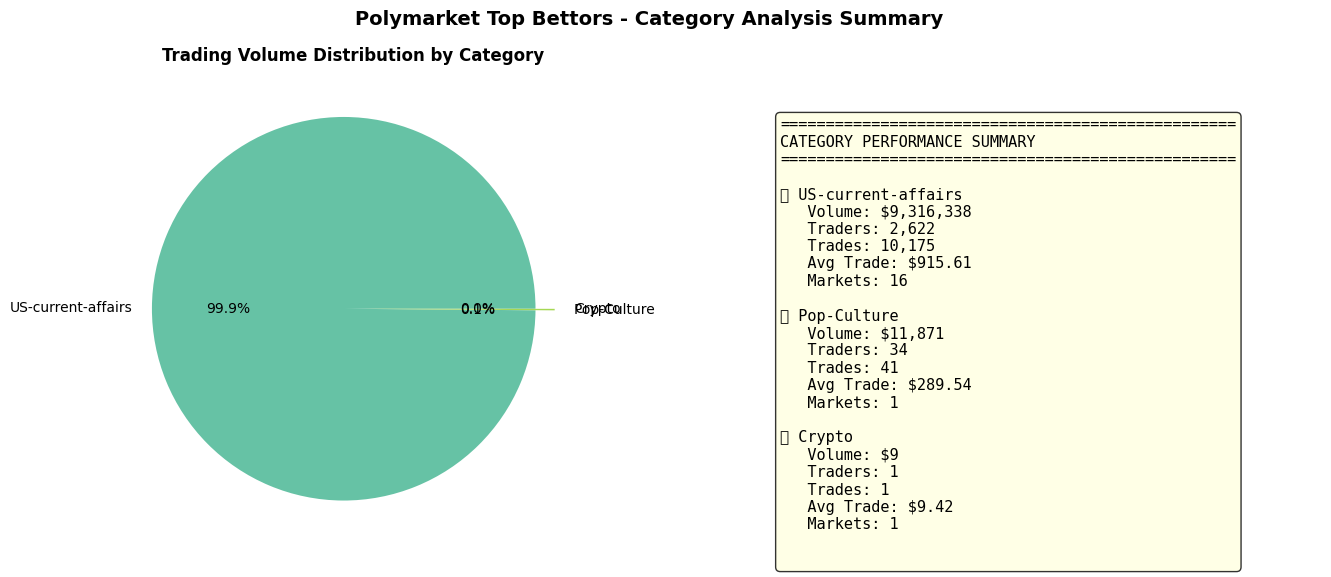

In [13]:
# Summary: Volume distribution pie chart and metrics table
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart for volume distribution by category
ax1 = axes[0]
colors = plt.cm.Set2(np.linspace(0, 1, len(category_stats)))
wedges, texts, autotexts = ax1.pie(
    category_stats['total_volume'], 
    labels=category_stats['category'],
    autopct='%1.1f%%',
    colors=colors,
    explode=[0.05] * len(category_stats)
)
ax1.set_title('Trading Volume Distribution by Category', fontsize=12, fontweight='bold')

# Metrics comparison table as text
ax2 = axes[1]
ax2.axis('off')

# Create a summary table
summary_text = "=" * 50 + "\n"
summary_text += "CATEGORY PERFORMANCE SUMMARY\n"
summary_text += "=" * 50 + "\n\n"

for _, row in category_stats.iterrows():
    summary_text += f"📊 {row['category']}\n"
    summary_text += f"   Volume: ${row['total_volume']:,.0f}\n"
    summary_text += f"   Traders: {row['unique_traders']:,}\n"
    summary_text += f"   Trades: {row['total_trades']:,}\n"
    summary_text += f"   Avg Trade: ${row['avg_trade_size']:.2f}\n"
    summary_text += f"   Markets: {row['unique_markets']}\n\n"

ax2.text(0.1, 0.9, summary_text, fontsize=11, fontfamily='monospace',
         verticalalignment='top', transform=ax2.transAxes,
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.suptitle('Polymarket Top Bettors - Category Analysis Summary', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [14]:
# Show top performers table with shortened wallet addresses
top_performers_display = top_bettors_by_category[['category', 'proxyWallet', 'rank_in_category', 'trade_count', 'total_volume', 'markets_traded']].copy()
top_performers_display['wallet_short'] = top_performers_display['proxyWallet'].apply(lambda x: f"{x[:8]}...{x[-6:]}")
top_performers_display['total_volume_fmt'] = top_performers_display['total_volume'].apply(lambda x: f"${x:,.2f}")

# Create a styled display
print("=" * 80)
print("TOP BETTORS BY CATEGORY - DETAILED BREAKDOWN")
print("=" * 80)

for category in top_performers_display['category'].unique():
    cat_data = top_performers_display[top_performers_display['category'] == category]
    print(f"\n🏆 {category.upper()}")
    print("-" * 60)
    for _, row in cat_data.iterrows():
        print(f"  #{int(row['rank_in_category'])}: {row['wallet_short']}")
        print(f"      Volume: {row['total_volume_fmt']} | Trades: {row['trade_count']} | Markets: {row['markets_traded']}")
    print()

TOP BETTORS BY CATEGORY - DETAILED BREAKDOWN

🏆 CRYPTO
------------------------------------------------------------
  #1: 0x6dd631...a0f5f4
      Volume: $9.42 | Trades: 1 | Markets: 1


🏆 POP-CULTURE 
------------------------------------------------------------
  #1: 0x569e37...bc67db
      Volume: $5,022.03 | Trades: 3 | Markets: 1
  #2: 0x01e813...c7ce3b
      Volume: $4,071.68 | Trades: 1 | Markets: 1
  #3: 0x57ee88...fc7f26
      Volume: $450.00 | Trades: 1 | Markets: 1
  #4: 0xd15db4...319f78
      Volume: $350.00 | Trades: 1 | Markets: 1
  #5: 0x17d5e2...d895a6
      Volume: $328.00 | Trades: 4 | Markets: 1


🏆 US-CURRENT-AFFAIRS
------------------------------------------------------------
  #1: 0x6356fb...b41885
      Volume: $321,658.05 | Trades: 97 | Markets: 5
  #2: 0x0c0e27...d0434e
      Volume: $247,129.90 | Trades: 50 | Markets: 7
  #3: 0xb53289...5a916b
      Volume: $238,887.84 | Trades: 35 | Markets: 4
  #4: 0x9d84ce...dc1344
      Volume: $225,431.17 | Trades: 58 | M

In [15]:
# Close DuckDB connection
conn.close()
print("Analysis complete. Connection closed.")

Analysis complete. Connection closed.


In [16]:
# Re-establish connection and calculate average return for US-current-affairs
conn = duckdb.connect(":memory:")
polymarket_db = Path(r"C:\Users\User\Desktop\VibeCoding\PolyMarketData\polymarket.duckdb")
conn.execute(f"ATTACH '{polymarket_db}' AS marketdb (READ_ONLY)")

conn.execute(f"""
    CREATE VIEW trades AS 
    SELECT * FROM read_parquet('{TRADES_GLOB}', hive_partitioning=true)
""")
conn.execute(f"""
    CREATE VIEW gamma_markets AS 
    SELECT * FROM read_parquet('{MARKETS_GLOB}', hive_partitioning=true)
""")

# Calculate average returns for US-current-affairs traders
# Return = (Sell Volume - Buy Volume) / Buy Volume for realized trades
us_current_affairs_returns = conn.execute("""
    WITH trader_pnl AS (
        SELECT 
            t.proxyWallet,
            SUM(CASE WHEN t.side = 'BUY' THEN t.size * t.price ELSE 0 END) as buy_volume,
            SUM(CASE WHEN t.side = 'SELL' THEN t.size * t.price ELSE 0 END) as sell_volume,
            SUM(CASE WHEN t.side = 'SELL' THEN t.size * t.price ELSE -t.size * t.price END) as net_pnl,
            COUNT(*) as trade_count,
            COUNT(DISTINCT t.conditionId) as markets_traded
        FROM trades t
        INNER JOIN gamma_markets gm ON t.conditionId = gm.conditionId
        WHERE gm.category = 'US-current-affairs'
        GROUP BY t.proxyWallet
        HAVING COUNT(*) >= 2  -- At least 2 trades for meaningful analysis
    )
    SELECT 
        COUNT(*) as total_traders,
        AVG(net_pnl) as avg_net_pnl,
        AVG(CASE WHEN buy_volume > 0 THEN (sell_volume - buy_volume) / buy_volume * 100 END) as avg_return_pct,
        SUM(net_pnl) as total_net_pnl,
        SUM(buy_volume) as total_buy_volume,
        SUM(sell_volume) as total_sell_volume,
        AVG(trade_count) as avg_trades_per_trader
    FROM trader_pnl
""").fetchdf()

print("=== US-Current-Affairs Average Returns ===")
display(us_current_affairs_returns)

# More detailed breakdown
print("\n=== Top 10 Traders by Return % (min 5 trades) ===")
top_returns = conn.execute("""
    WITH trader_pnl AS (
        SELECT 
            t.proxyWallet,
            SUM(CASE WHEN t.side = 'BUY' THEN t.size * t.price ELSE 0 END) as buy_volume,
            SUM(CASE WHEN t.side = 'SELL' THEN t.size * t.price ELSE 0 END) as sell_volume,
            COUNT(*) as trade_count
        FROM trades t
        INNER JOIN gamma_markets gm ON t.conditionId = gm.conditionId
        WHERE gm.category = 'US-current-affairs'
        GROUP BY t.proxyWallet
        HAVING COUNT(*) >= 5 AND SUM(CASE WHEN t.side = 'BUY' THEN t.size * t.price ELSE 0 END) > 100
    )
    SELECT 
        proxyWallet,
        buy_volume,
        sell_volume,
        sell_volume - buy_volume as net_pnl,
        (sell_volume - buy_volume) / buy_volume * 100 as return_pct,
        trade_count
    FROM trader_pnl
    ORDER BY return_pct DESC
    LIMIT 10
""").fetchdf()
display(top_returns)

=== US-Current-Affairs Average Returns ===


,total_traders,avg_net_pnl,avg_return_pct,total_net_pnl,total_buy_volume,total_sell_volume,avg_trades_per_trader
0,1514,-1278.603822,82.071127,-1.935806e+06,5.437512e+06,3.501706e+06,5.988771



=== Top 10 Traders by Return % (min 5 trades) ===


,proxyWallet,buy_volume,sell_volume,net_pnl,return_pct,trade_count
0,0xee292607d48ecee93afc0fe9994fbe316f59c56d,689.500000,20734.398400,20044.898400,2907.164380,6
1,0x4c1858c7f6a3161020ae57a66268a0fa52c1c578,606.380000,14076.809540,13470.429540,2221.450170,15
2,0x7789806c754eb0af4c3abeb026c218b4ba78f823,8623.411742,131780.062551,123156.650809,1428.166189,34
3,0x7a81d5d0bd724ebd82979a83309eb29dc2286d56,322.639994,2871.049600,2548.409606,789.861658,16
4,0x7f2de588e3d990d66fef63bf2378dacc87a139a8,3773.309997,32765.756200,28992.446203,768.355800,6
5,0x6c10edcab1106314a72d68cab84197b733384e76,350.499994,2810.333000,2459.833006,701.806861,17
6,0x60073655845c95014a540ae3f7375b15801647a3,8200.001599,61560.351500,53360.349901,650.735848,5
7,0x0d364461a91d9cda0cacebb7ef5a40ffd1e5e7ae,204.000000,1367.541100,1163.541100,570.363284,5
8,0x92967e678a1a001875feb69b7c512bbcf7bbe89c,3034.253099,14485.538300,11451.285201,377.400462,30
9,0xbae9bdaeae9a80e9bcfb4e1fde5abaa9630fdc3a,313.619300,1478.945400,1165.326100,371.573465,11


In [ ]:
# Top traders by category (using MarketDim if available)
try:
    traders_by_category = conn.execute(f"""
        SELECT 
            m.category,
            t.proxyWallet,
            COUNT(*) as trade_count,
            SUM(t.size * t.price) as total_volume,
            AVG(t.price) as avg_price
        FROM trades t
        LEFT JOIN marketdb.MarketDim m ON t.conditionId = m.external_id
        WHERE m.category IS NOT NULL
        GROUP BY m.category, t.proxyWallet
        ORDER BY m.category, total_volume DESC
    """).fetchdf()
    
    print("=== Traders by Category ===")
    display(traders_by_category.head(50))
except Exception as e:
    print(f"Could not analyze by category: {e}")

In [ ]:
# Top 5 traders per category
try:
    top_per_category = conn.execute(f"""
        WITH ranked AS (
            SELECT 
                m.category,
                t.proxyWallet,
                COUNT(*) as trade_count,
                SUM(t.size * t.price) as total_volume,
                ROW_NUMBER() OVER (PARTITION BY m.category ORDER BY SUM(t.size * t.price) DESC) as rank
            FROM trades t
            LEFT JOIN marketdb.MarketDim m ON t.conditionId = m.external_id
            WHERE m.category IS NOT NULL
            GROUP BY m.category, t.proxyWallet
        )
        SELECT *
        FROM ranked
        WHERE rank <= 5
        ORDER BY category, rank
    """).fetchdf()
    
    print("=== Top 5 Traders Per Category ===")
    display(top_per_category)
except Exception as e:
    print(f"Could not analyze top per category: {e}")

In [ ]:
# Category performance Before vs After November 2024
try:
    category_time_split = conn.execute(f"""
        SELECT 
            m.category,
            CASE WHEN t.timestamp < {nov_2024_ts} THEN 'Before Nov 2024' ELSE 'After Nov 2024' END as period,
            COUNT(*) as trade_count,
            COUNT(DISTINCT t.proxyWallet) as unique_traders,
            SUM(t.size * t.price) as total_volume
        FROM trades t
        LEFT JOIN marketdb.MarketDim m ON t.conditionId = m.external_id
        WHERE m.category IS NOT NULL
        GROUP BY m.category, period
        ORDER BY m.category, period
    """).fetchdf()
    
    print("=== Category Performance: Before vs After November 2024 ===")
    display(category_time_split)
except Exception as e:
    print(f"Could not analyze category time split: {e}")

In [ ]:
# Pivot table for category comparison
try:
    category_pivot = category_time_split.pivot_table(
        index='category',
        columns='period',
        values=['trade_count', 'unique_traders', 'total_volume'],
        aggfunc='sum'
    ).fillna(0)
    
    print("=== Category Pivot: Before vs After ===")
    display(category_pivot)
except Exception as e:
    print(f"Could not create pivot: {e}")

## Trader Category Specialization

In [ ]:
# Find traders who specialize in specific categories
try:
    specialist_traders = conn.execute(f"""
        WITH trader_category_volume AS (
            SELECT 
                t.proxyWallet,
                m.category,
                SUM(t.size * t.price) as category_volume
            FROM trades t
            LEFT JOIN marketdb.MarketDim m ON t.conditionId = m.external_id
            WHERE m.category IS NOT NULL
            GROUP BY t.proxyWallet, m.category
        ),
        trader_total AS (
            SELECT 
                proxyWallet,
                SUM(category_volume) as total_volume
            FROM trader_category_volume
            GROUP BY proxyWallet
        )
        SELECT 
            tcv.proxyWallet,
            tcv.category,
            tcv.category_volume,
            tt.total_volume,
            tcv.category_volume / tt.total_volume * 100 as category_pct
        FROM trader_category_volume tcv
        JOIN trader_total tt ON tcv.proxyWallet = tt.proxyWallet
        WHERE tt.total_volume > 1000  -- Filter for active traders
        AND tcv.category_volume / tt.total_volume > 0.5  -- More than 50% in one category
        ORDER BY category_pct DESC, total_volume DESC
        LIMIT 30
    """).fetchdf()
    
    print("=== Category Specialist Traders (>50% in one category) ===")
    display(specialist_traders)
except Exception as e:
    print(f"Could not find specialist traders: {e}")

## Summary Statistics

In [ ]:
# Overall summary
print("=" * 60)
print("BACKTEST SUMMARY")
print("=" * 60)

# Before November 2024 stats
before_stats = conn.execute(f"""
    SELECT 
        COUNT(*) as trades,
        COUNT(DISTINCT proxyWallet) as traders,
        SUM(size * price) as volume
    FROM trades
    WHERE timestamp < {nov_2024_ts}
""").fetchone()

# After November 2024 stats  
after_stats = conn.execute(f"""
    SELECT 
        COUNT(*) as trades,
        COUNT(DISTINCT proxyWallet) as traders,
        SUM(size * price) as volume
    FROM trades
    WHERE timestamp >= {nov_2024_ts}
""").fetchone()

print(f"\nBEFORE November 2024:")
print(f"  Trades: {before_stats[0]:,}")
print(f"  Unique Traders: {before_stats[1]:,}")
print(f"  Total Volume: ${before_stats[2]:,.2f}" if before_stats[2] else "  Total Volume: N/A")

print(f"\nAFTER November 2024:")
print(f"  Trades: {after_stats[0]:,}")
print(f"  Unique Traders: {after_stats[1]:,}")
print(f"  Total Volume: ${after_stats[2]:,.2f}" if after_stats[2] else "  Total Volume: N/A")

In [ ]:
# Cleanup
conn.close()
print("Connection closed.")